In [14]:
import sys
sys.path.append("C:/Users/cnava/Repos/PolaPy")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.ticker as mtick

from polapy.competitiveness import blais_lago, grofman_selb, election_competitiveness
from polapy.polarization import election_polarization, esteban_ray

from agent_model import ElectionModel


### Election with 2 candidates, 3 districts

In [74]:
def reorder(input_list):
    length = len(input_list)
    output = []
    for i in range(int(np.ceil(length/2))):
        if i == 0:
            output.append(input_list[i])
            output.append(input_list[length-1])
        else:
            output.append(input_list[i])
            output.append(input_list[-i-1])

    return output[0:length]


In [186]:
candidates = ["A", "B"]
output = []
e_id = 1
for election_id, p in enumerate([
    ([0.5, 0.5]),
    ([0.6, 0.4]),
    ([0.7, 0.3]),
    ([0.8, 0.2]),
    ([0.9, 0.1]),
    ([1.0, 0.0])
]):
    for iteration in range(10):
        model = ElectionModel(N=10000, candidates=candidates, p=p)
        model.step()

        df = pd.DataFrame([x.choice for x in model.schedule.agents], columns=["candidate"])
        df["votes"] = 1
        # df = df.sort_values("candidate")

        for sorting in [2, 100, 500, 1000, 2500, 5000]:
            df_temp = df.copy()
            df_temp["election_id"] = e_id
            e_id += 1

            df_temp = pd.concat(reorder(np.array_split(df_temp, sorting)))

            for i, frag in enumerate(np.array_split(df_temp, 1000)):
                frag["unit"] = i + 1
                output.append(frag)

data = pd.concat(output, ignore_index=True)
data = data.groupby(["election_id", "unit", "candidate"]).agg({"votes": "sum"}).reset_index()
data.head()


,election_id,unit,candidate,votes
0,1,1,A,4
1,1,1,B,6
2,1,2,A,6
3,1,2,B,4
4,1,3,A,7


In [188]:
data

,election_id,unit,candidate,votes
0,1,1,A,4
1,1,1,B,6
2,1,2,A,6
3,1,2,B,4
4,1,3,A,7
...,...,...,...,...
630669,360,996,A,10
630670,360,997,A,10
630671,360,998,A,10
630672,360,999,A,10


In [191]:
output = []
output_data = []
for i, frag in data.groupby("election_id"):
    ec, ant = election_competitiveness(frag)
    ep, ant = election_polarization(frag)
    output_data.append({
        "election_id": i,
        "ec": ec,
        "ep": ep
    })

    d = frag.groupby(["unit", "candidate"]).agg({"votes": "sum"}).unstack().fillna(0).stack()
    d["share"] = d.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
    d = d.reset_index()
    d["election_id"] = i
    output.append(d)

df = pd.concat(output, ignore_index=True)

C:\Users/cnava/Repos/PolaPy\polapy\competitiveness\election_competitiveness.py:42: RuntimeWarning: invalid value encountered in double_scalars
  dv_between = 0 if np.sum(values_c).sum() == 0 else np.sum(
C:\Users/cnava/Repos/PolaPy\polapy\competitiveness\election_competitiveness.py:42: RuntimeWarning: invalid value encountered in double_scalars
  dv_between = 0 if np.sum(values_c).sum() == 0 else np.sum(
C:\Users/cnava/Repos/PolaPy\polapy\competitiveness\election_competitiveness.py:42: RuntimeWarning: invalid value encountered in double_scalars
  dv_between = 0 if np.sum(values_c).sum() == 0 else np.sum(
C:\Users/cnava/Repos/PolaPy\polapy\competitiveness\election_competitiveness.py:42: RuntimeWarning: invalid value encountered in double_scalars
  dv_between = 0 if np.sum(values_c).sum() == 0 else np.sum(
C:\Users/cnava/Repos/PolaPy\polapy\competitiveness\election_competitiveness.py:42: RuntimeWarning: invalid value encountered in double_scalars
  dv_between = 0 if np.sum(values_c).sum(

In [199]:
agg = data.groupby(["election_id", "candidate"]).agg({"votes": "sum"}).unstack().fillna(0).stack()
agg["share"] = agg.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
agg = agg.reset_index()
agg = agg.pivot(index="election_id", columns=["candidate"], values="share").reset_index()
agg["margin_of_victory"] = np.absolute(agg["A"] - agg["B"])
agg

candidate,election_id,A,B,margin_of_victory
0,1,0.5133,0.4867,0.0266
1,2,0.5133,0.4867,0.0266
2,3,0.5133,0.4867,0.0266
3,4,0.5133,0.4867,0.0266
4,5,0.5133,0.4867,0.0266
...,...,...,...,...
355,356,1.0000,0.0000,1.0000
356,357,1.0000,0.0000,1.0000
357,358,1.0000,0.0000,1.0000
358,359,1.0000,0.0000,1.0000


In [203]:
std = df.groupby(["election_id", "candidate"]).agg({"share": "std"}).reset_index()
std = std[std["candidate"] == "A"].rename(columns={"share": "std"})
std

,election_id,candidate,std
0,1,A,0.163094
2,2,A,0.163094
4,3,A,0.163094
6,4,A,0.163094
8,5,A,0.164378
...,...,...,...
655,356,A,0.000000
656,357,A,0.000000
657,358,A,0.000000
658,359,A,0.000000


In [221]:
df_ec = pd.DataFrame(output_data)
df_ec = pd.merge(df_ec, agg, on="election_id")
df_ec = pd.merge(df_ec, std, on="election_id")
df_ec["mov"] = pd.cut(df_ec["margin_of_victory"], bins=10)
df_ec.head()

,election_id,ec,ep,A,B,margin_of_victory,candidate,std,mov
0,1,0.745966,0.258952,0.5133,0.4867,0.0266,A,0.163094,"(0.0026, 0.103]"
1,2,0.745966,0.258952,0.5133,0.4867,0.0266,A,0.163094,"(0.0026, 0.103]"
2,3,0.745966,0.258952,0.5133,0.4867,0.0266,A,0.163094,"(0.0026, 0.103]"
3,4,0.745966,0.258952,0.5133,0.4867,0.0266,A,0.163094,"(0.0026, 0.103]"
4,5,0.742762,0.262052,0.5133,0.4867,0.0266,A,0.164378,"(0.0026, 0.103]"


<AxesSubplot: xlabel='mov', ylabel='ec'>

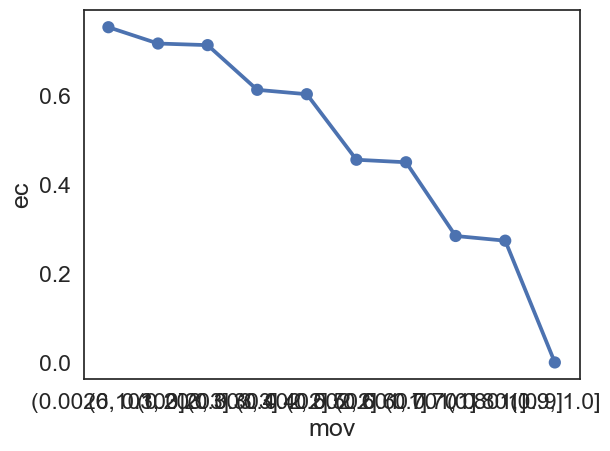

In [227]:
sns.pointplot(data=df_ec, x="mov", y="ec")


C:\Users\cnava\AppData\Local\Temp\ipykernel_51772\3479468189.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(y="share", palette=["blue", "red", "#1DBB8C"], hue="candidate", x="election_id", data=df)


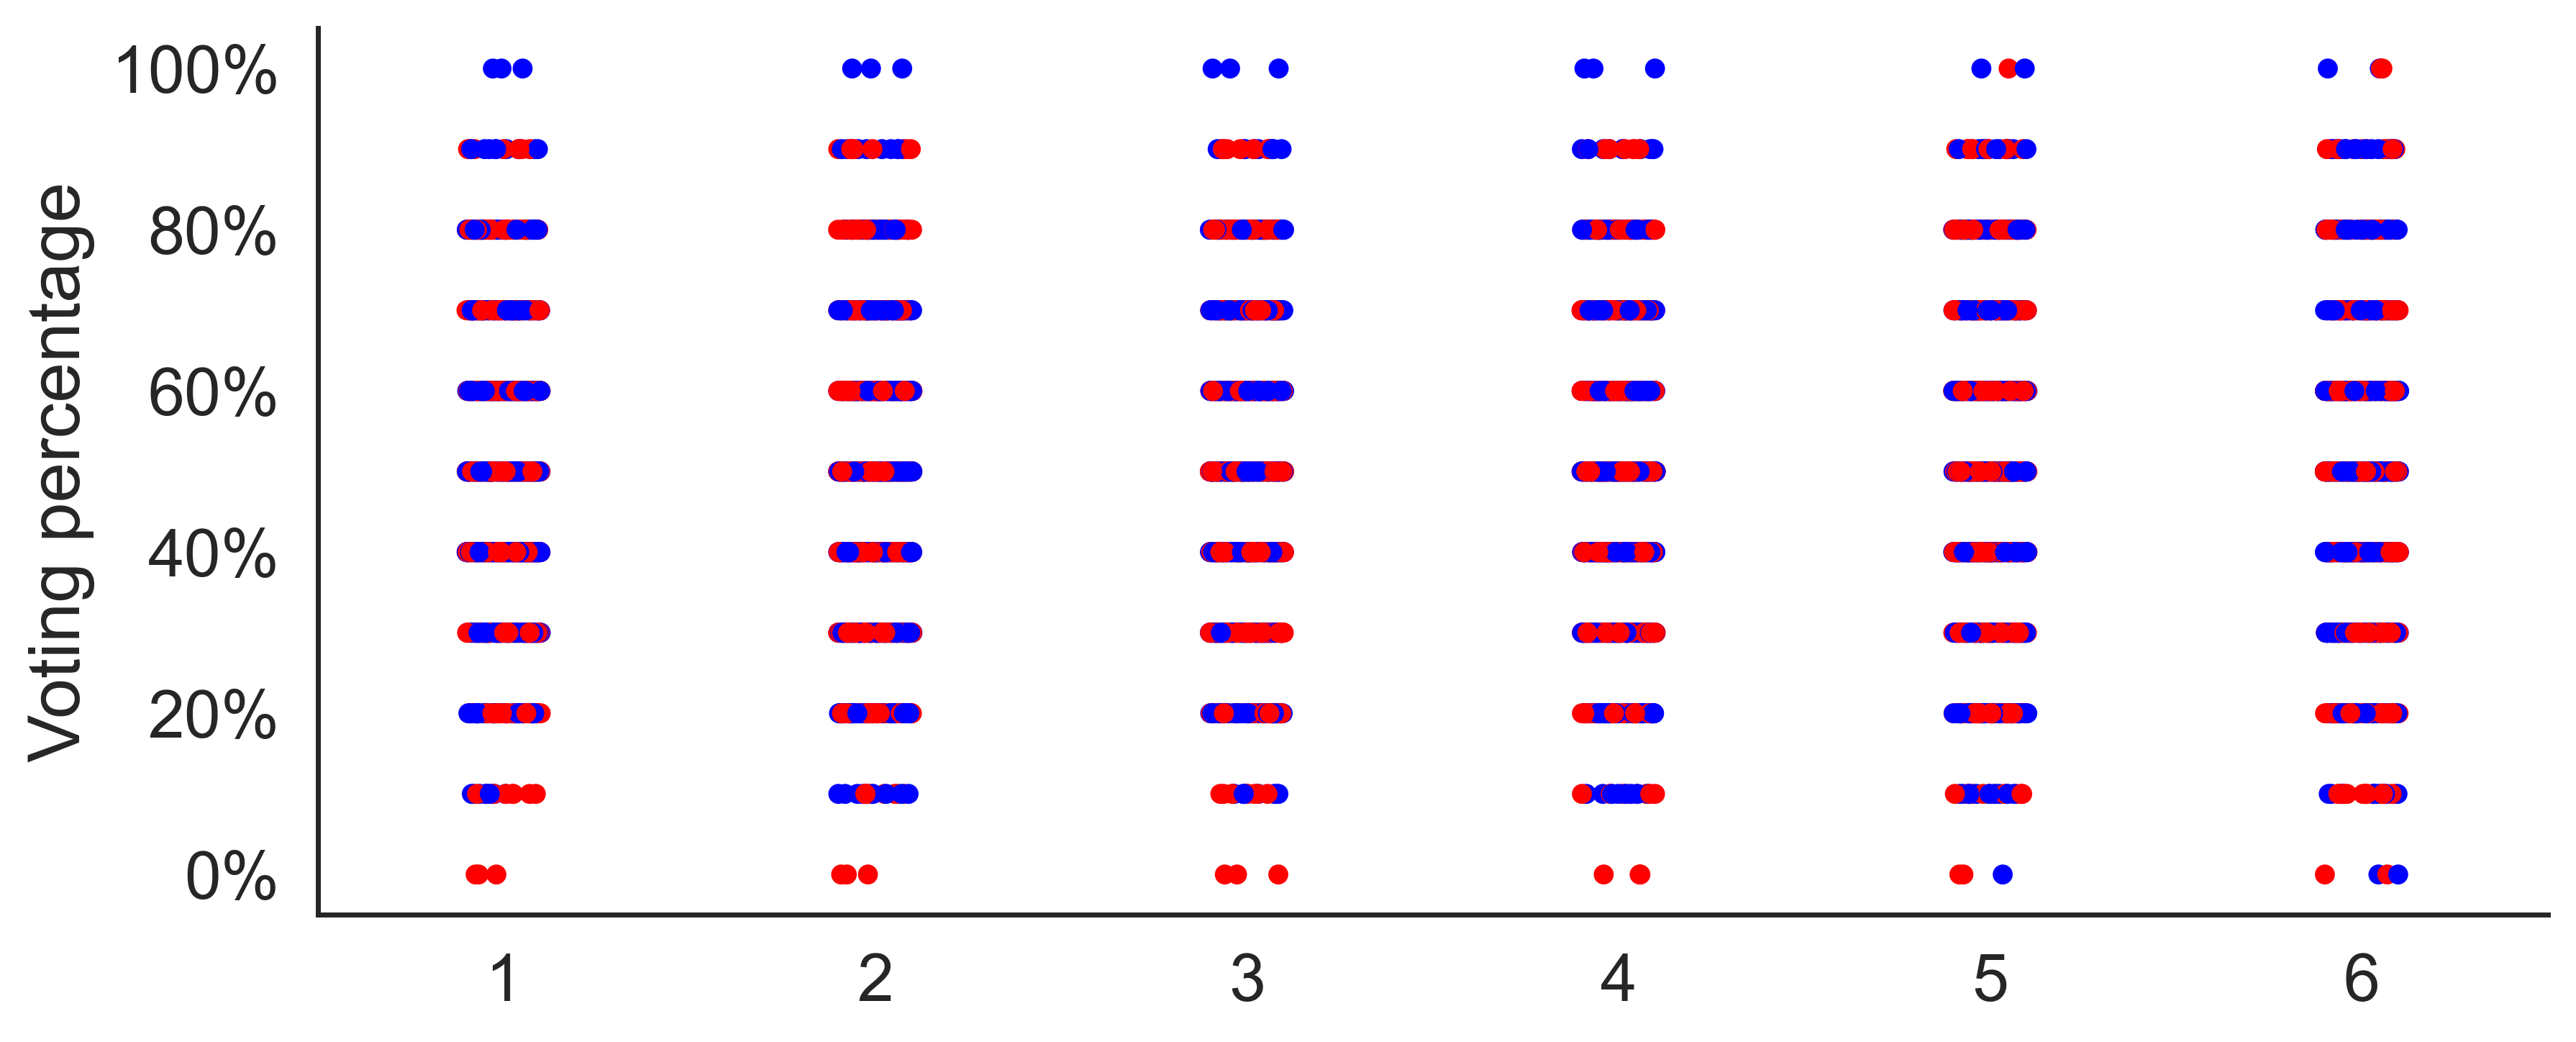

In [185]:
sns.set(font_scale=1.5, style="white")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=400)

sns.stripplot(y="share", palette=["blue", "red", "#1DBB8C"], hue="candidate", x="election_id", data=df)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

# lbls = []
# for i, dd in df.groupby("election_id"):
#     lbls.append(f"EP={round(epi[i]['total'], 2)}\nBetween={round(epi[i]['between'], 2)}\nWithin={round(epi[i]['within'], 2)}")

# ax.set_xticklabels(lbls, fontsize=14)

leg = ax.legend()
leg.remove()
ax.set_xlabel("")
ax.set_ylabel("Voting percentage")
sns.despine()